<a href="https://colab.research.google.com/github/2359181042/GNN_cs224w/blob/main/%E2%80%9CIreland_wells_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric
!pip install pytorch_lightning

     |████████████████████████████████| 3.0 MB 34.1 MB/s 
     |████████████████████████████████| 1.6 MB 18.3 MB/s 
     |████████████████████████████████| 222 kB 35.9 MB/s 
     |████████████████████████████████| 376 kB 20.7 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 913 kB 42.2 MB/s 
     |████████████████████████████████| 118 kB 72.6 MB/s 
     |████████████████████████████████| 234 kB 62.1 MB/s 
     |████████████████████████████████| 636 kB 55.9 MB/s 
     |████████████████████████████████| 10.6 MB 40.1 MB/s 
     |████████████████████████████████| 829 kB 43.4 MB/s 
     |████████████████████████████████| 1.3 MB 30.6 MB/s 
     |████████████████████████████████| 294 kB 58.5 MB/s 
     |████████████████████████████████| 142 kB 61.2 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=054d314ecb2d586f17d29b485d94b90d96898393238c5cd5ed083a6caf0bec74
  Stored in directory: /root/.cache/p

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import os
import json
import numpy as np
import pandas as pd
DATA_PATH = 'gdrive/My Drive/Ireland_data/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/gdrive


In [3]:

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib
from matplotlib.pyplot import figure


import pandas as pd
import numpy as np
from tqdm import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid',palette='muted',font_scale = 1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize']=12,8
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. analyze our data 
  #### The data include eight wells between Galway City and Lahinch City in Ireland island. We consider the hourly data from 2016.11.28 13:00-2021.7.1 0:00: groundwater level, thelog_elevation, and the rain, temp and vapour pressure.

In [4]:
df=pd.read_csv(os.path.join(DATA_PATH,'Data1.csv'))
loc=pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))
df['Date'] = pd.to_datetime(df['Time'])
df['Day'] = df['Date'].dt.day
df['Month']=df['Date'].dt.month
df['Year']=df['Date'].dt.year
df['Hour']=df['Date'].dt.hour
df.index=df['Date']
df=df.drop(['Time'],axis=1)
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
cols = df.columns.tolist()
cols = cols[-4:]+cols[:-4]
df=df[cols]
df = df.rename(columns={'Lough Aleenaun': 'O1L', 'Unnamed: 2': 'O1E','Termon South':'O2L','Unnamed: 4':'O2E',  'Coole Lough':'O3L','Unnamed: 6':'O3E', 'Caherglassaun':'O4L','Unnamed: 8':'O4E', 'Black Rock':'O5L', 'Unnamed: 10':'O5E',
                        'Labane':'O6L','Unnamed: 12':'O6E','Caranavoodaun':'O7L', 'Unnamed: 14':'O7E'})


df.columns


Index(['Day', 'Month', 'Year', 'Hour', 'O1L', 'O1E', 'O2L', 'O2E', 'O3L',
       'O3E', 'O4L', 'O4E', 'O5L', 'O5E', 'O6L', 'O6E', 'O7L', 'O7E', 'rain',
       'temp', 'vp', 'Date'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40140 entries, 2016-12-01 13:00:00 to 2021-07-01 00:00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Day               40140 non-null  int64         
 1   Month             40140 non-null  int64         
 2   Year              40140 non-null  int64         
 3   Hour              40140 non-null  int64         
 4   O1L               39720 non-null  float64       
 5   O1E               39720 non-null  float64       
 6   O2L               40140 non-null  float64       
 7   O2E               40140 non-null  float64       
 8   O3L               39391 non-null  float64       
 9   O3E               39391 non-null  float64       
 10  O4L               33890 non-null  float64       
 11  O4E               33890 non-null  float64       
 12  O5L               39476 non-null  float64       
 13  O5E               39476 non-null  float64

In [ ]:
len(df['O2L'])

40140

<Figure size 1280x400 with 0 Axes>

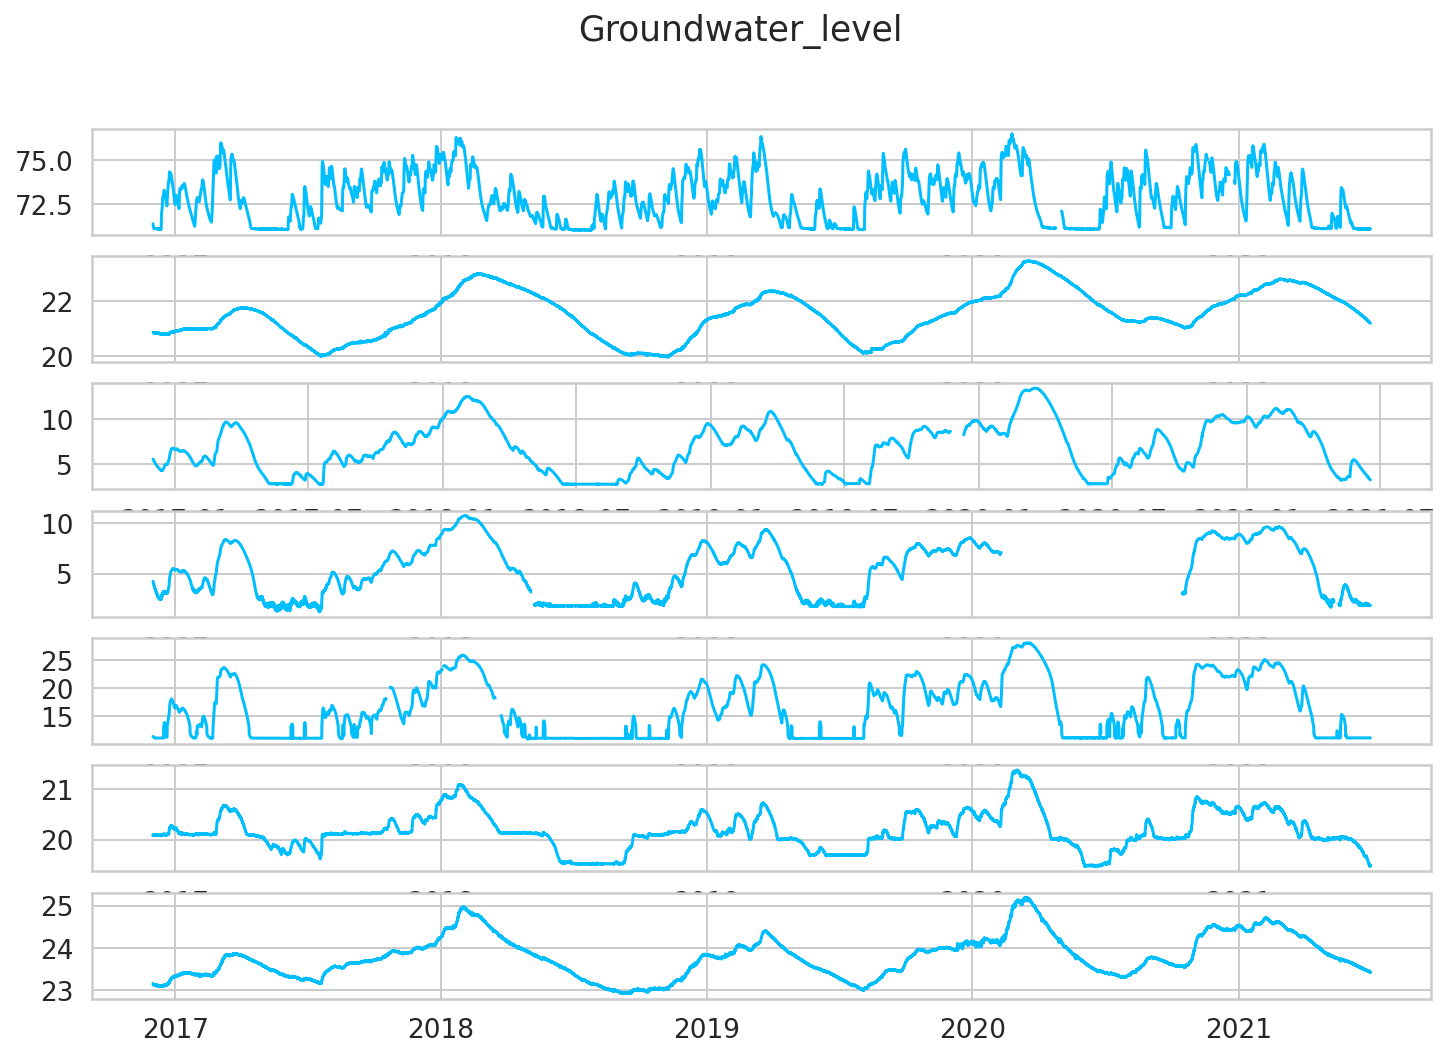

In [ ]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(7)
fig.suptitle('Groundwater_level')
axs[0].plot(df.index, df['O1L'])
axs[1].plot(df.index, df['O2L'])
axs[2].plot(df.index, df['O3L'])
axs[3].plot(df.index, df['O4L'])
axs[4].plot(df.index, df['O5L'])
axs[5].plot(df.index, df['O6L'])
axs[6].plot(df.index, df['O7L'])


In [ ]:
df2.head()

,Day,Month,Year,Hour,O1L,O1E,O2L,O2E,O3L,O3E,O4L,O4E,O5L,O5E,O6L,O6E,O7L,O7E,rain,temp,vp,Date
Date,,,,,,,,,,,,,,,,,,,,,,
2016-12-01 13:00:00,1,12,2016,13,71.365,70.87,20.861,19.73,5.584,2.85,4.242,0.0,11.362,11.08,20.090,19.53,23.154,22.21,0.0,6.5,7.4,2016-12-01 13:00:00
2016-12-01 14:00:00,1,12,2016,14,71.357,70.87,20.864,19.73,5.581,2.85,4.227,0.0,11.358,11.08,20.094,19.53,23.153,22.21,0.0,6.8,7.6,2016-12-01 14:00:00
2016-12-01 15:00:00,1,12,2016,15,71.348,70.87,20.863,19.73,5.574,2.85,4.208,0.0,11.351,11.08,20.096,19.53,23.156,22.21,0.0,6.4,7.5,2016-12-01 15:00:00
2016-12-01 16:00:00,1,12,2016,16,71.330,70.87,20.856,19.73,5.560,2.85,4.180,0.0,11.336,11.08,20.088,19.53,23.146,22.21,0.0,3.4,6.8,2016-12-01 16:00:00
2016-12-01 17:00:00,1,12,2016,17,71.322,70.87,20.858,19.73,5.556,2.85,4.162,0.0,11.330,11.08,20.090,19.53,23.142,22.21,0.0,1.5,6.3,2016-12-01 17:00:00


In [6]:
df2=df
df2['O1E']=df2['O1E'].fillna(method='ffill', axis=0)
df2['O3E']=df2['O3E'].fillna(method='ffill', axis=0)
df2['O4E']=df2['O4E'].fillna(method='ffill', axis=0)
df2['O5E']=df2['O5E'].fillna(method='ffill', axis=0)
df2['O1L']=df2['O1L'].fillna(method='ffill', axis=0)
df2['O3L']=df2['O3L'].fillna(method='ffill', axis=0)
df2['O5L']=df2['O5L'].fillna(method='ffill', axis=0)
df2['O4L']=df2['O4L'].fillna(method='ffill', axis=0)
df2=df2.drop(['O1E'],axis=1)
df2=df2.drop(['O1L'],axis=1)

<Figure size 1280x400 with 0 Axes>

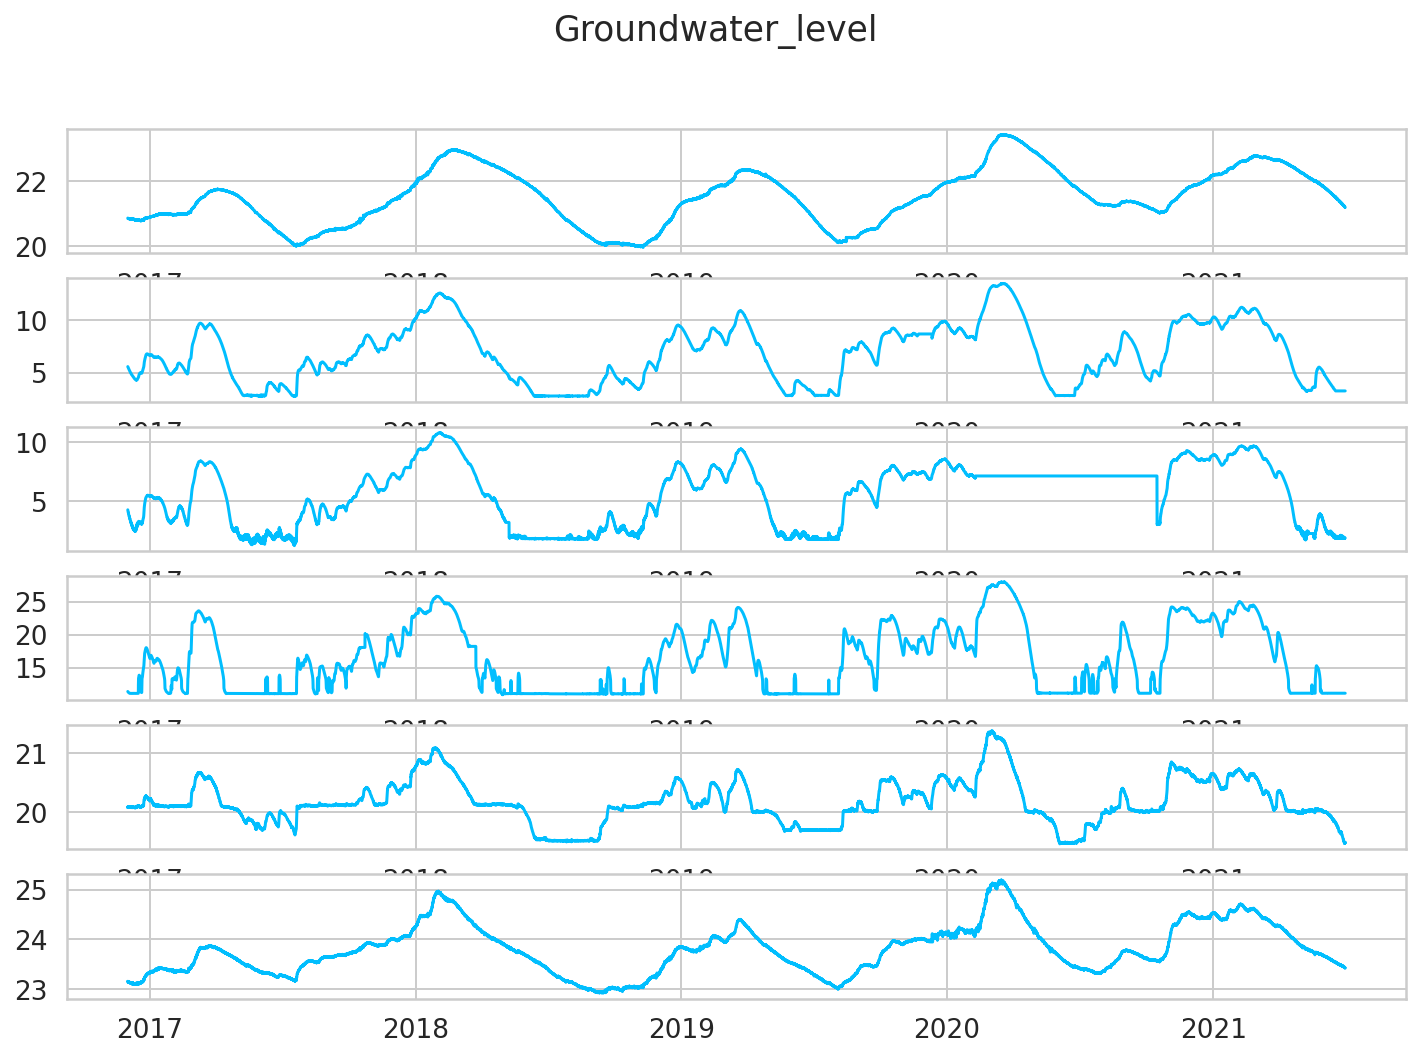

In [9]:
figure(figsize=(16, 5), dpi=80)
fig, axs = plt.subplots(6)
fig.suptitle('Groundwater_level')

axs[0].plot(df2.index, df2['O2L'])
axs[1].plot(df2.index, df2['O3L'])
axs[2].plot(df2.index, df2['O4L'])
axs[3].plot(df2.index, df2['O5L'])
axs[4].plot(df2.index, df2['O6L'])
axs[5].plot(df2.index, df2['O7L'])

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40140 entries, 2016-12-01 13:00:00 to 2021-07-01 00:00:00
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Day     40140 non-null  int64         
 1   Month   40140 non-null  int64         
 2   Year    40140 non-null  int64         
 3   Hour    40140 non-null  int64         
 4   O2L     40140 non-null  float64       
 5   O2E     40140 non-null  float64       
 6   O3L     40140 non-null  float64       
 7   O3E     40140 non-null  float64       
 8   O4L     40140 non-null  float64       
 9   O4E     40140 non-null  float64       
 10  O5L     40140 non-null  float64       
 11  O5E     40140 non-null  float64       
 12  O6L     40140 non-null  float64       
 13  O6E     40140 non-null  float64       
 14  O7L     40140 non-null  float64       
 15  O7E     40140 non-null  float64       
 16  rain    40140 non-null  float64       
 17  temp    40140 n

## Now the data are cleaned for 1 2 3 5 6 7, while 4 is lacking.

## The training data can be from 2017-2020,test data can be later

In [11]:
rows=[]
for _, row in tqdm(df2.iterrows(),total = df2.shape[0]):
  row_data=dict(
      O2L=row.O2L,
      O3L=row.O3L,
      O4L=row.O4L,
      O5L=row.O5L,
      O6L=row.O6L,
      O7L=row.O7L,
      O2E=row.O2E,
      O3E=row.O3E,
      O4E=row.O4E,
      O5E=row.O5E,
      O6E=row.O6E,
      O7E=row.O7E,
      rain=row.rain,
      temp=row.temp,
      vp=row.vp,
      day=row.Day,
      month=row.Month,
      year=row.Year,
      hour=row.Hour
  )
  rows.append(row_data)
features_df=pd.DataFrame(rows)

100%|██████████| 40140/40140 [00:10<00:00, 3845.49it/s]


In [15]:
features_df

,O2L,O3L,O4L,O5L,O6L,O7L,O2E,O3E,O4E,O5E,O6E,O7E,rain,temp,vp,day,month,year,hour
0,20.861,5.584,4.242,11.362,20.090,23.154,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.5,7.4,1,12,2016,13
1,20.864,5.581,4.227,11.358,20.094,23.153,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.8,7.6,1,12,2016,14
2,20.863,5.574,4.208,11.351,20.096,23.156,19.73,2.85,0.00,11.08,19.53,22.21,0.0,6.4,7.5,1,12,2016,15
3,20.856,5.560,4.180,11.336,20.088,23.146,19.73,2.85,0.00,11.08,19.53,22.21,0.0,3.4,6.8,1,12,2016,16
4,20.858,5.556,4.162,11.330,20.090,23.142,19.73,2.85,0.00,11.08,19.53,22.21,0.0,1.5,6.3,1,12,2016,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40135,21.201,3.270,1.856,11.100,19.493,23.425,20.27,2.85,1.73,11.08,19.50,22.70,0.0,19.7,15.2,30,6,2021,20
40136,21.198,3.270,1.852,11.096,19.488,23.425,20.27,2.85,1.73,11.08,19.50,22.70,0.0,14.4,13.0,30,6,2021,21
40137,21.198,3.270,1.848,11.098,19.488,23.422,20.27,2.85,1.73,11.08,19.50,22.70,0.0,11.9,12.2,30,6,2021,22
40138,21.194,3.270,1.848,11.096,19.490,23.421,20.27,2.85,1.73,11.08,19.50,22.70,0.0,11.9,12.6,30,6,2021,23


In [12]:
train_size= int(len(features_df)*0.6)
val_size=int(len(features_df)*0.85)
test_size=int(len(features_df)*0.95)
print(train_size,val_size,test_size)

24084 34119 38133


In [13]:
train_df=features_df[:train_size]
val_df=features_df[val_size:test_size]
test_df=features_df[test_size:]
print(len(train_df),len(val_df),len(test_df))

24084 4014 2007


# Currently not need transformation, because reverse transformation is difficult.

In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler = scaler.fit(train_df)

In [ ]:
train_df=pd.DataFrame(
    scaler.trainsform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [ ]:
val_df=pd.DataFrame(
    scaler.trainsform(val_df),
    index=train_df.index,
    columns=val_df.columns
)

In [ ]:
test_df=pd.DataFrame(
    scaler.trainsform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

# Above are transformation

In [14]:
def create_sequences(input_data:pd.DataFrame,number,TIME_WINDOW,PRED_TIME):
  sequences=[]
  data_size=len(input_data)
  #print(number)
  for i in tqdm(range(data_size-TIME_WINDOW-PRED_TIME)):
    sequence = input_data[i:i+TIME_WINDOW]
    weather_for = input_data.iloc[i+TIME_WINDOW:i+TIME_WINDOW+PRED_TIME,14:17]
    label = input_data.iloc[i+TIME_WINDOW:i+TIME_WINDOW+PRED_TIME,0:number]
    #print(f'label{label}')
    sequences.append((sequence,weather_for,label))
  return sequences


In [ ]:
sample_data=pd.DataFrame(dict(
    feature_1=[1,2,3,4,5,6,7],
    label=[8,9,10,11,12,13,14],
    label2=[8,9,10,11,12,13,14]
))
sample_data.head()

,feature_1,label,label2
0,1,8,8
1,2,9,9
2,3,10,10
3,4,11,11
4,5,12,12


In [ ]:
sample_data.iloc[2:4,0:2]

,feature_1,label
2,3,10
3,4,11


In [ ]:
sample_sequences = create_sequences(sample_data,number=2,TIME_WINDOW=3,PRED_TIME=1)

100%|██████████| 3/3 [00:00<00:00, 1520.78it/s]


In [ ]:
print(sample_sequences[0][0])
print(f'label:{sample_sequences[0][1]}')

   feature_1  label  label2
0          1      8       8
1          2      9       9
2          3     10      10
label:   feature_1  label
3          4     11


In [16]:
number=6
TIME_WINDOW=240
PRED_TIME=24
train_sequences=create_sequences(train_df,number,TIME_WINDOW,PRED_TIME)
val_sequences=create_sequences(val_df,number,TIME_WINDOW,PRED_TIME)
test_sequences=create_sequences(test_df,number,TIME_WINDOW,PRED_TIME)

100%|██████████| 1743/1743 [00:01<00:00, 1642.44it/s]


In [ ]:
print(len(train_sequences)/128)

186.09375


In [17]:
print(train_sequences[0][0].shape)
print(train_sequences[0][1].shape)
print(train_sequences[0][2].shape)

(240, 19)
(24, 3)
(24, 6)


In [ ]:
#Don't need now
O1L=df2['O1L'].to_numpy()
print(O1L.shape)
O2L=df2['O2L'].to_numpy()
O3L=df2['O3L'].to_numpy()
O4L=df2['O4L'].to_numpy()
O5L=df2['O5L'].to_numpy()
O6L=df2['O6L'].to_numpy()
O7L=df2['O7L'].to_numpy()
print(O4L.shape)
O1E=df2['O1E'].to_numpy()
print(O1L.shape)
O2E=df2['O2E'].to_numpy()
O3E=df2['O3E'].to_numpy()
O4E=df2['O4E'].to_numpy()
O5E=df2['O5E'].to_numpy()
O6E=df2['O6E'].to_numpy()
O7E=df2['O7E'].to_numpy()
rain=df2['rain'].to_numpy()
temp=df2['temp'].to_numpy()
vp=df2['Vapour Pressure '].to_numpy()
Day=df2['Day'].to_numpy()
Month=df2['Month'].to_numpy()
Year=df2['Year'].to_numpy()
Hour=df2['Hour'].to_numpy()

(40140,)
(40140,)
(40140,)


KeyError: ignored

In [18]:

Well_location= pd.read_csv(os.path.join(DATA_PATH,'sets.csv'))

NE=[]
North=[]
East=[]
for i in range(2,8):
    N=Well_location.iloc[0][i]
    North.append(N)
    E=Well_location.iloc[1][i]
    East.append(E)
    NE.append((N,E))
print(len(NE))
print(NE)
print(North)
print(East)

6
[(53.022037, 8.873746), (53.086776, 8.849339), (53.104572999999995, 8.870828), (53.121168999999995, 8.751982), (53.139996, 8.804413), (53.184284999999996, 8.810231)]
[53.022037, 53.086776, 53.104572999999995, 53.121168999999995, 53.139996, 53.184284999999996]
[8.873746, 8.849339, 8.870828, 8.751982, 8.804413, 8.810231]


In [25]:
from math import sin, cos, sqrt, atan2, radians
R = 6378.1370
specific_distance=7
def get_conn_attr(N,E):
    Distance = []
    con_i=[]
    con_j=[]
    for i in range(len(N)):
        for j in range(len(N)):
          #print('this is Ni',N[i],E[i])
          lat1 = radians(N[i])
          lon1 = radians(E[i])
          lat2 = radians(N[j])
          lon2 = radians(E[j])
          dlon = lon2 - lon1
          dlat = lat2 - lat1
          a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
          c = 2 * atan2(sqrt(a), sqrt(1 - a))
          distance = R * c
          if (distance < specific_distance) & (distance > 0):
              con_i.append(i)
              con_j.append(j)
              Distance.append(distance)

    conn=torch.tensor([con_i,con_j])
    edge_attr = torch.tensor([Distance])
    edge_attr = edge_attr.transpose(0, 1) 
    edge_attr = edge_attr.unsqueeze(0).repeat(6,1,1)
    return conn, edge_attr

In [ ]:
Conn,Edge_attr=get_conn_attr(North,East)
print(Conn)
print(Edge_attr)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import os
import json
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians





In [ ]:
type(conn)

torch.Tensor

In [28]:
class WellDataset(Dataset):
  def __init__(self,sequences,conn,edge_attr):
    self.sequences= sequences
    self.conn=conn
    self.edge_attr=edge_attr
  def __len__(self):
    return len(self.sequences)

  def __getitem__(self, index):
    sequence,weather_for,label=self.sequences[index]
    return dict(
        sequence=torch.Tensor(sequence.to_numpy()),
        weather_for=torch.Tensor(weather_for.to_numpy()),
        conn=self.conn,
        edge_attr=self.edge_attr,
        label= torch.Tensor(label.to_numpy()).float()       
    )

In [29]:
class WellDataModule(pl.LightningDataModule):
  def __init__(
      self, train_sequences, val_sequences,test_sequences,North,East,batch_size
  ):
    super().__init__()
    self.conn=Conn
    self.edge_attr=Edge_attr
    self.train_sequences=train_sequences
    self.val_sequences=val_sequences
    self.test_sequences=test_sequences
    self.batch_size=batch_size
  def setup(self):
    self.train_dataset= WellDataset(self.train_sequences,self.conn,self.edge_attr)
    self.val_dataset= WellDataset(self.val_sequences,self.conn,self.edge_attr)
    self.test_dataset=WellDataset(self.test_sequences,self.conn,self.edge_attr)
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
        self.val_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=2
    )

In [ ]:
train_dataset= WellDataset(train_sequences,conn,edge_attr)

NameError: ignored

In [ ]:
for item in train_dataset:
  print(item['weather_for'].shape)
  print(item['conn'])
  print(item['edge_attr'].shape)
  print(item['sequence'].shape)
  print(item['label'].shape)

  
  break

torch.Size([24, 3])
tensor([[1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6],
        [2, 3, 1, 3, 4, 5, 1, 2, 4, 5, 6, 2, 3, 5, 6, 2, 3, 4, 6, 3, 4, 5]])
torch.Size([7, 22, 1])
torch.Size([240, 21])
tensor([[71.0610, 20.8030,  4.3720,  2.4260, 11.0710, 20.0810, 23.0990],
        [71.0630, 20.8050,  4.3720,  2.4200, 11.0700, 20.0820, 23.1020],
        [71.0630, 20.8040,  4.3690,  2.4510, 11.0720, 20.0800, 23.0960],
        [71.0610, 20.8020,  4.3670,  2.5200, 11.0700, 20.0810, 23.0960],
        [71.0610, 20.8030,  4.3640,  2.5600, 11.0720, 20.0810, 23.0960],
        [71.0610, 20.8040,  4.3630,  2.5780, 11.0730, 20.0850, 23.1010],
        [71.0590, 20.8010,  4.3580,  2.5760, 11.0710, 20.0810, 23.1010],
        [71.0620, 20.8040,  4.3580,  2.5680, 11.0730, 20.0820, 23.1050],
        [71.0620, 20.8050,  4.3560,  2.5480, 11.0740, 20.0840, 23.1010],
        [71.0580, 20.8020,  4.3500,  2.5210, 11.0730, 20.0820, 23.0990],
        [71.0570, 20.8000,  4.3450,  2.4870, 11.0730

# Model

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean, scatter_add
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNEncoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

    def forward(self, x, h0, c0):
        # Set initial hidden and cell states
        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h0, c0))  
        # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        return h_n, c_n
class RNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNDecoder, self).__init__()
        self.input_size=input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)
        self.lin = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x, h_0, c_0):
        # Forward propagate LSTM
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out = self.lin(out)
        out = self.relu(out)
        # Decode the hidden state of the last time step
        return out, h_n, c_n

In [32]:

class WellModel(nn.Module):
  def __init__(self, L_em,E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h):
    super(WellModel,self).__init__()
    self.L_em=L_em
    self.E_em=E_em
    self.T_em=T_em
    self.W_em=W_em
    self.well_num=well_num
    self.rnn_h=rnn_h
    self.gnn_h=gnn_h
    self.rnn_l=rnn_l

    self.L_embed = nn.Sequential(
      nn.Linear(1,self.L_em),
      nn.ReLU()
    )
    self.E_embed = nn.Sequential(
      nn.Linear(1,self.E_em),
      nn.ReLU()
    )
    self.T_embed = nn.Sequential(
      nn.Linear(4,self.T_em),
      nn.ReLU()
    )
    self.W_embed = nn.Sequential(
      nn.Linear(3,self.W_em),
      nn.ReLU()
    )    
    self.well_gnn=WellGNN(64,1,self.gnn_h) # node feature is the sum of em, edge feature is 1
    self.encoder = RNNEncoder(input_size=self.gnn_h,
                  hidden_size=self.rnn_h,
                  num_layers=self.rnn_l)
    self.decoder_embed=nn.Sequential(
      nn.Linear(1,self.L_em),            
      nn.ReLU()            
    )
    self.decoder=RNNDecoder(input_size=self.L_em+self.W_em,
                hidden_size=self.rnn_h,
                num_layers=self.rnn_l)
  def batchInput(self,x,edge_w,edge_conn):
    x=x.reshape(-1,x.shape[-1])
    edge_w=edge_w.reshape(-1,edge_w.shape[-1])    
    for i in range(edge_conn.size(0)):
      edge_conn[i,:]=torch.add(edge_conn[i,:],i*self.well_num) 
    edge_conn=edge_conn.transpose(0,1)                     
    edge_conn=edge_conn.reshape(2,-1)
    return x,edge_w,edge_conn
  def forward(self,sequence_data,device):
    features,weather_for,conn,edge_attr=sequence_data
    #print(features.shape)
    #print(weather_for.shape)
    L=features[:,:,:6]
    E=features[:,:,6:12]
    W=features[:,:,12:15]
    T=features[:,:,[17,16,15,18]]

    Lev=L.unsqueeze(dim=-1).to(torch.float32)
    Lev=self.L_embed(Lev)
    
    Ele=E.unsqueeze(dim=-1).to(torch.float32)
    Ele=self.E_embed(Ele)

    Wea=W.unsqueeze(dim=-2).to(torch.float32)
    Wea=self.W_embed(Wea)
    Wea=Wea.repeat(1,1,6,1)

    Tim=T.unsqueeze(dim=-2).to(torch.float32)
    Tim=self.T_embed(Tim)
    Tim=Tim.repeat(1,1,6,1)
    #print("Four features size",Lev.shape,Ele.shape,Wea.shape,Tim.shape)
    x=torch.cat([Lev,Ele,Wea,Tim],dim=-1) #
    #print("x before torch.cat",x.shape)
    conn=conn.repeat(self.well_num,1,1).to(torch.float32)
    edge_attr = edge_attr.reshape(-1, edge_attr.shape[-2], edge_attr.shape[-1]).to(torch.float32) 
    #print('This is x.shape,conn.shape,edge_attr.shape',x.shape,conn.shape,edge_attr.shape) 
    x, edge_attr, conn = self.batchInput(x, edge_attr, conn)
    x = self.well_gnn(x, conn,edge_attr )
    x = x.reshape(-1, TIME_WINDOW, self.well_num, x.shape[-1]).transpose(1, 2)
    x = x.reshape(-1, TIME_WINDOW, x.shape[-1])
    h0 = torch.randn(self.rnn_l, x.size(0), self.rnn_h).to(device)
    c0 = torch.randn(self.rnn_l, x.size(0), self.rnn_h).to(device)
    h_x, c_x = self.encoder(x, h0, c0)

    outputs = torch.zeros((x.size(0), weather_for.size(1), 1)).to(device)

    QL=L.transpose(1,2).to(torch.float32)
    QL=QL[:, :, -1].reshape(-1, 1)
    weather_for=weather_for.repeat(self.well_num,1,1).to(torch.float32)
    weather_for=self.W_embed(weather_for)
    #print('come here')
    for i in range(weather_for.size(1)):
      QL_em=self.decoder_embed(QL)
      inputs=torch.cat((QL_em,weather_for[:,i]),dim=-1)
      inputs=inputs.unsqueeze(dim=1)
      output,h_x,c_x=self.decoder(inputs,h_x,c_x)
      output = output.reshape(-1,1)
      outputs[:,i]=output
      QL=output
    outputs=outputs.reshape(-1,self.well_num,weather_for.size(1))
    #print("output.shape",outputs.shape)
    return outputs

class WellGNN(torch.nn.Module):
  def __init__(self,node_h=64,edge_h=2,gnn_h=32):
    super(WellGNN,self).__init__()
    self.node_mlp_1 =nn.Sequential(
      nn.Linear(2 * node_h + edge_h, gnn_h),
      nn.ReLU(inplace=True)
    )

    self.node_mlp_2 =nn.Sequential(
      nn.Linear(node_h + gnn_h, gnn_h),
      nn.ReLU(inplace=True)
    )
  def forward(self, x, edge_index, edge_attr):
    # x: [N, F_x], where N is the number of nodes.
    # edge_index: [2, E] with max entry N - 1.
    # edge_attr: [E, F_e]
    #u = u.reshape(-1, u.shape[-1])
    #u = u.repeat(sta_num, 1)
    row, col = edge_index
    row = row.type(torch.LongTensor)
    col = col.type(torch.LongTensor) # need to be torch.longTensor type

    #torch.LongTensor(rows)    

    out = torch.cat([x[row], x[col], edge_attr], dim=1)
    out = self.node_mlp_1(out)
    out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
    out = torch.cat([x, out], dim=1) #delete u
    return self.node_mlp_2(out)

In [33]:
TIME_WINDOW=240
PRED_TIME=24
L_em=16
E_em=16
T_em=16
W_em=16
well_num=6
rnn_h=64
gnn_h=32
rnn_l=1
lr=0.001
Epoch=10
BATCH_SIZE=128

In [34]:
model=WellModel(L_em,E_em,T_em, W_em,well_num, rnn_h, rnn_l, gnn_h).to(device)
model_num = sum(p.numel() for p in model.parameters()
                      if p.requires_grad)
print('model:', 'Trainable,', model_num)
criterion = nn.MSELoss()
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.001)

val_loss_min = 1
data_module=WellDataModule(train_sequences,val_sequences,test_sequences,Conn,Edge_attr,batch_size=BATCH_SIZE)
data_module.setup()

model: Trainable, 57745


In [ ]:
test=iter(data_module.train_dataloader())
data=test.next()
print(data.keys())
#print(data['sequence'])
print(data['conn'])


In [35]:
#@title 默认标题文本
a=[]
b=[]
c=[]
d=[]
for epoch in range(Epoch):
  for i,data in enumerate(data_module.train_dataloader()):
    features= data['sequence'].to(device)
    weather_for=data['weather_for'].to(device)
    conn=data['conn'].to(device)
    edge_attr=data['edge_attr'].to(device)
    label=data['label'].transpose(1,2).to(device) #128*24*7 -> 128*7*24
    sequences=[features,weather_for,conn,edge_attr]
    outputs = model(sequences,device)
    #print('label',label.shape)
    a.append((outputs,label))
    
    loss = criterion(outputs, label)
    b.append(loss.item())
    #a.append(loss.item())
    model.zero_grad()
    loss =loss
    loss.backward() 
    optimizer.step()
    if i % 1 ==0 and epoch % 1 ==0:
      print("Epoch [{}/{}], step [{}/{}],loss {:.4f} ".format(
          epoch,10,i,int(len(train_sequences)/BATCH_SIZE),loss.item()
      ))
  val_loss=0
  with torch.no_grad():
    for j,data in enumerate(data_module.val_dataloader()):
      features= data['sequence'].to(device)
      weather_for=data['weather_for'].to(device)
      conn=data['conn'].to(device)
      edge_attr=data['edge_attr'].to(device)
      label=data['label'].transpose(1,2).to(device)
      sequences=[features,weather_for,conn,edge_attr]
      outputs = model(sequences,device)
      c.append((outputs,label))  
      val_loss= criterion(outputs, label)
      d.append(loss.item())
      if epoch % 1 ==0 and j==0:
        name = F'temp_model{epoch}:{j}.ckpt'
        path = F"/content/gdrive/My Drive/{name}" 
        torch.save(model.state_dict(), path)
        

    if val_loss < val_loss_min and epoch > (Epoch * 0.7):
      print('Model can be saved')
      model_save_name = F'FINAL_Ireland_well{epoch}.ckpt'
      path = F"/content/gdrive/My Drive/{model_save_name}" 
      torch.save(model.state_dict(), path)  
      #torch.save(model.state_dict(),'./checkpoints/global.ckpt')
    
      val_loss_min = val_loss
print('Finished Training')


Epoch [8/10], step [14/186],loss 2.8907 


KeyboardInterrupt: ignored

In [ ]:

model_save_name = F'FINAL_Ireland_well9.ckpt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)  

In [ ]:
print(len(a))
print(len(b))
print(len(c))
print(len(d))

1870
1870
37500
37500


In [37]:
train_outputs=[]
train_y=[]
for i in range(len(a)):
  train_outputs.append(a[i][0])
  train_y.append(a[i][1])
print(len(train_outputs))

1512


In [38]:
val_outputs=[]
val_y=[]
for i in range(len(c)):
  val_outputs.append(c[i][0])
  val_y.append(c[i][1])
print(len(val_outputs))

30000


In [39]:
torch.save(train_outputs, F"/content/gdrive/My Drive/train_outputs.pt")

In [40]:
torch.save(train_y, F"/content/gdrive/My Drive/train_y.pt")

In [41]:
torch.save(val_outputs, F"/content/gdrive/My Drive/val_outputs.pt")

In [42]:
torch.save(val_y, F"/content/gdrive/My Drive/val_y.pt")

In [43]:
torch.save(b, F"/content/gdrive/My Drive/train_loss.pt")

In [44]:
torch.save(d, F"/content/gdrive/My Drive/val_loss.pt")

In [45]:
new_outputs=torch.load(F"/content/gdrive/My Drive/val_outputs.pt")
print(new_outputs[2500] == val_outputs[2500])
print(new_outputs[1800]) 

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True, True, True,
          True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, Tru

torch.Size([1, 6, 24])
tensor(3.9119)
tensor([19.0924, 21.3685, 21.9941, 22.1477, 22.1939, 22.2101, 22.2181, 22.2213,
        22.2238, 22.2247, 22.2261, 22.2257, 22.2277, 22.2284, 22.2314, 22.2347,
        22.2368, 22.2396, 22.2401, 22.2399, 22.2395, 22.2406, 22.2411, 22.2413])
tensor([20.1960, 20.1920, 20.1960, 20.1910, 20.1920, 20.1870, 20.1880, 20.1880,
        20.1880, 20.1870, 20.1850, 20.1800, 20.1830, 20.1810, 20.1800, 20.1780,
        20.1730, 20.1710, 20.1710, 20.1670, 20.1660, 20.1630, 20.1610, 20.1560])


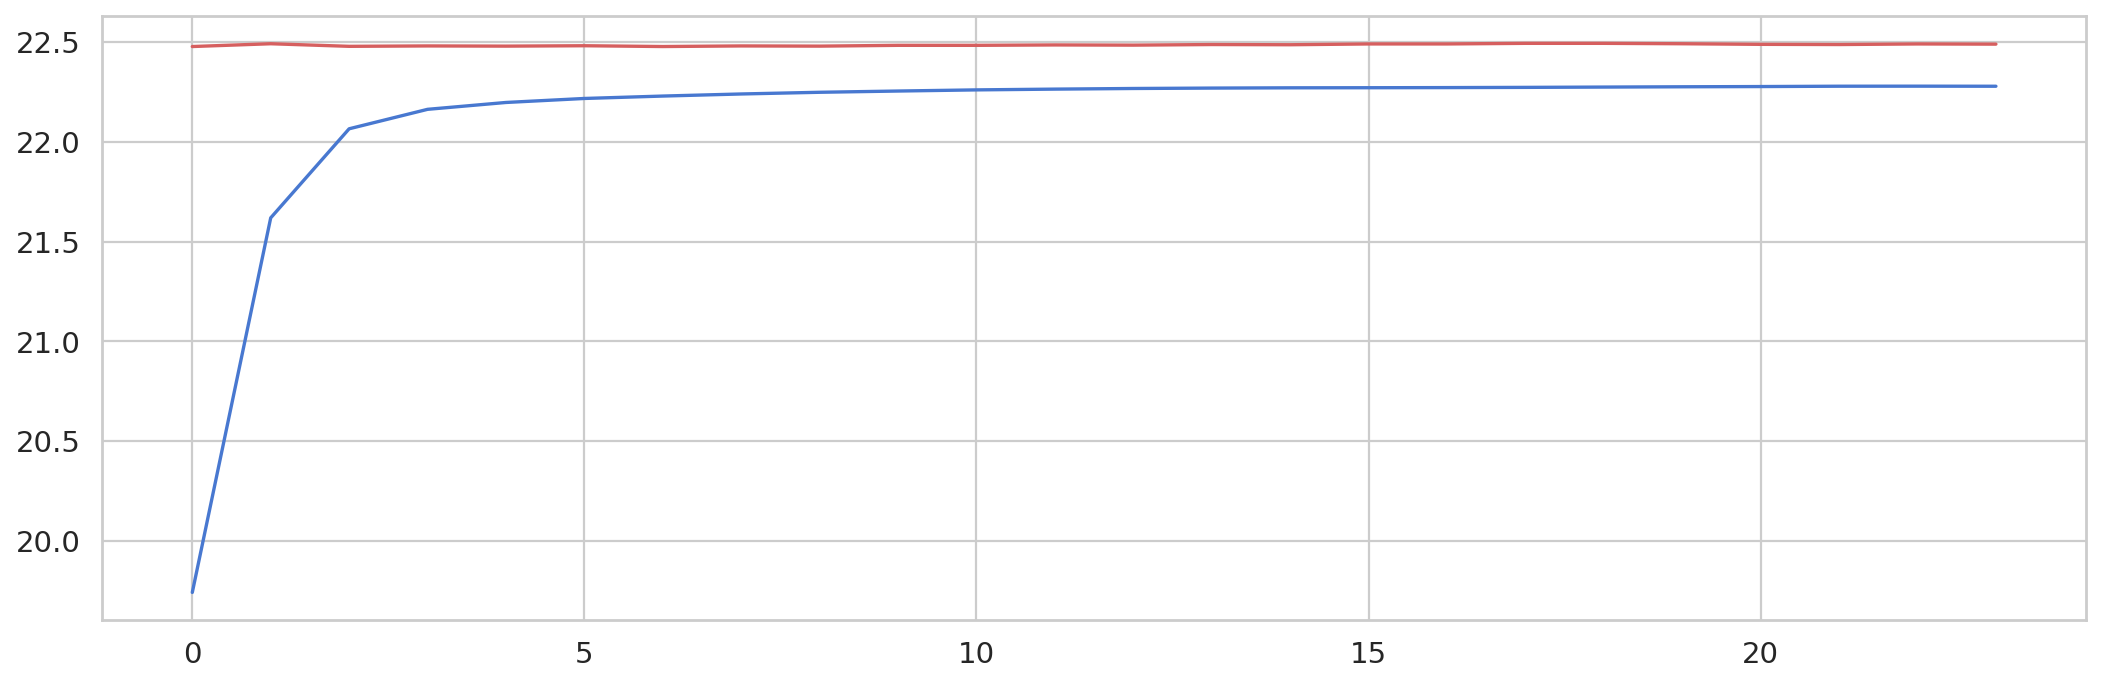

In [71]:
print(val_outputs[29999].shape)
print(criterion(val_outputs[29999][0][4],val_y[29999][0][4],))
print(val_outputs[29999][0][4])
print(val_y[29999][0][4])
x=range(24)
figure(figsize=(16, 5), dpi=80)

fig.suptitle('Groundwater_level')

plt.plot(x,val_outputs[28400][0][0],'b',val_y[28400][0][0],'r')



In [ ]:
with open("test.txt", "r") as fp:
     b = json.load(fp)

In [ ]:
for item in a:
  print(item[0].shape)
  print(item[1].shape)
  print(criterion(item[0], item[1]))
  print(criterion(item[0][1,1,1],item[1][1,1,1]))
  print(criterion(item[0][127,6,23],item[1][127,6,23]))
  break

torch.Size([128, 7, 24])
torch.Size([128, 7, 24])
tensor(968.9291, grad_fn=<MseLossBackward>)
tensor(432.8065, grad_fn=<MseLossBackward>)
tensor(534.4420, grad_fn=<MseLossBackward>)


In [ ]:
for item in c:
  print(item[0].shape)
  print(item[1].shape)
  print(criterion(item[0], item[1]))
  print(criterion(item[0][0,1,23],item[1][0,1,23]))

  break

torch.Size([1, 7, 24])
torch.Size([1, 7, 24])
tensor(587.6411)
tensor(48.1752)


In [ ]:
for epoch in range(3):
  model_save_name = F'Ireland_well{epoch}.ckpt'
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path) 
  for j in range(3):
    if epoch % 1 ==0 and j==0:
      name = F'temp_model{epoch}:{j}.ckpt'
      path = F"/content/gdrive/My Drive/{name}" 
      torch.save(model.state_dict(), path)